# Indeed Machine Learning Hackathon - Initial Model Building

This notebook walks through the predictive models that I explored during the competition. The prediction file from the SVM model below is what I submitted to get my final ranking of 27/248.

In [24]:
import preprocessing as pp
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
train = pp.JobDescriptionDataset("./data/train.tsv")
dt_matrix = train.getDTMatrix()
corr_matrix = train.getCorrelationMatrix()
corr_matrix_sort = (-corr_matrix).argsort()
term_names = train.getTermNames()

### Data Preprocessing

I restrict my input document term matrix to include only terms that are in the top 15 most correlated with some tag.

In [26]:
top_terms = np.array(list(set(corr_matrix_sort[:, :15].flatten().tolist()[0])))
X = dt_matrix[:, top_terms]
y = train.getBinarizedLabels()

I hold out a 30% validation set for comparing models.

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=24)

Load in the test data and transform to match training data.

In [28]:
test = pp.JobDescriptionDataset("./data/test.tsv")
test.setDTMatrix(vocab = np.array(train.getTermNames())[top_terms])
X_test = test.getDTMatrix()

### OneVsRest SVM

In [29]:
ovr_svm = OneVsRestClassifier(SVC(kernel = 'linear', probability = True, random_state = 20))
ovr_svm.fit(X_train, y_train)
ovr_svm_val_preds = ovr_svm.predict(X_val)

In [30]:
print "Validation Score -", pp.score(y_val, ovr_svm_val_preds)
print "Training Score -", pp.score(y_train, ovr_svm.predict(X_train))

Validation Score - Precision: 0.7627, Recall: 0.5892, F1: 0.6648
Training Score - Precision: 0.8188, Recall: 0.6393, F1: 0.7180


The precision is higher than the recall for this model which shows that it fails to predict many tags but does relatively well when it does predict a tag. This means that the model could likely benefit from predicting more tags to boost the true positive rate at the expense of increasing the false positive rate. In addition, the average number of tags predicted per sample in the validation set is significantly lower than the average number of tags per sample in the training set. This is another indication that the model could benefit from predicting more tags.

In [31]:
print "Average Tags Per Validation Prediction:", 1.*ovr_svm_val_preds.sum()/ovr_svm_val_preds.shape[0]
print "Average Tags Per Training Sample:", 1.*y_train.sum()/y_train.shape[0]

Average Tags Per Validation Prediction: 1.20335110434
Average Tags Per Training Sample: 1.57903331156


We can boost the number of tags predicted by using SVM's probability estimates and lowering the threshold at which a sample is predicted to have a certain tag. We can choose this threshold by looking at performance results on the validation set using various threshold values.

In [32]:
ovr_svm_val_preds_prob = ovr_svm.predict_proba(X_val)
grid_result = list()
for i in [.17 + incr for incr in np.divide(range(25), 100.)]:
    row = [i, 1.*(ovr_svm_val_preds_prob > i).sum()/ovr_svm_val_preds_prob.shape[0]]
    pred_matrix = ovr_svm_val_preds_prob > i
    row += list(pp.score(y_val, pred_matrix, return_values = True))
    grid_result.append(row)
grid_result = np.array(grid_result)

In [33]:
grid_result_pretty = pd.DataFrame(grid_result)
grid_result_pretty.columns = ["Threshold", "Avg. Tags Per Prediction", "Val. Precision", "Val. Recall", "Val. F1"]
display(grid_result_pretty)

,Threshold,Avg. Tags Per Prediction,Val. Precision,Val. Recall,Val. F1
0,0.17,1.917746,0.608022,0.748655,0.671050
1,0.18,1.843869,0.624535,0.739364,0.677116
2,0.19,1.786748,0.637681,0.731540,0.681394
3,0.20,1.736481,0.648246,0.722738,0.683468
4,0.21,1.687738,0.659296,0.714425,0.685755
5,0.22,1.644326,0.667439,0.704645,0.685538
6,0.23,1.603960,0.676638,0.696822,0.686582
7,0.24,1.561310,0.684878,0.686553,0.685714
8,0.25,1.525514,0.691962,0.677751,0.684783
9,0.26,1.495050,0.698421,0.670416,0.684132


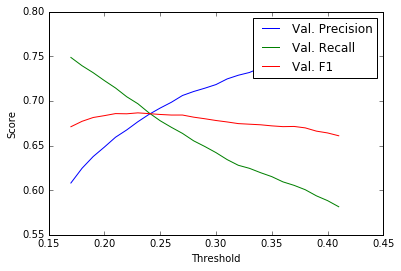

In [34]:
plt.plot(grid_result[:,0], grid_result[:,2:5])
plt.legend(["Val. Precision", "Val. Recall", "Val. F1"])
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.show()

In [35]:
print "Training Score -", pp.score(y_train, ovr_svm.predict_proba(X_train) > .235)

Training Score - Precision: 0.7497, Recall: 0.7297, F1: 0.7395


I'll fit this model on all the data to make test predictions.

In [36]:
ovr_svm.fit(X, y)
svm_test_preds = ovr_svm.predict_proba(X_test) > .235
svm_test_pred_str = pp.labelMatrixToString(svm_test_preds.astype(int))
# pp.predStringToFile(svm_test_pred_str, "./data/tags.tsv")

### OneVsRest Logistic Regression

In [37]:
ovr_lr = OneVsRestClassifier(LogisticRegression(random_state = 10))
ovr_lr.fit(X_train, y_train)
ovr_lr_val_preds_prob = ovr_lr.predict_proba(X_val)

In [38]:
grid_result = list()
for i in [.21 + incr for incr in np.divide(range(25), 100.)]:
    row = [i, 1.*(ovr_lr_val_preds_prob > i).sum()/ovr_lr_val_preds_prob.shape[0]]
    pred_matrix = ovr_lr_val_preds_prob > i
    row += list(pp.score(y_val, pred_matrix, return_values = True))
    grid_result.append(row)
grid_result = np.array(grid_result)

In [39]:
grid_result_pretty = pd.DataFrame(grid_result)
grid_result_pretty.columns = ["Threshold", "Avg. Tags Per Prediction", "Val. Precision", "Val. Recall", "Val. F1"]
display(grid_result_pretty)

,Threshold,Avg. Tags Per Prediction,Val. Precision,Val. Recall,Val. F1
0,0.21,1.976390,0.603854,0.766259,0.675431
1,0.22,1.941356,0.610435,0.760880,0.677405
2,0.23,1.900990,0.618590,0.755012,0.680026
3,0.24,1.865956,0.625714,0.749633,0.682091
4,0.25,1.830922,0.632696,0.743765,0.683749
5,0.26,1.792079,0.641734,0.738386,0.686676
6,0.27,1.759330,0.649351,0.733496,0.688863
7,0.28,1.720487,0.656485,0.725183,0.689126
8,0.29,1.686215,0.663957,0.718826,0.690303
9,0.30,1.651181,0.672970,0.713447,0.692618


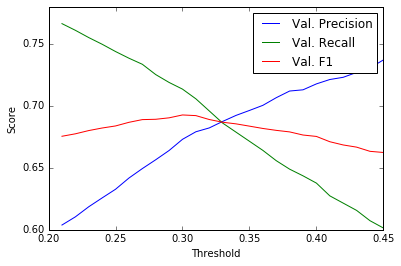

In [40]:
plt.plot(grid_result[:,0], grid_result[:,2:5])
plt.legend(["Val. Precision", "Val. Recall", "Val. F1"])
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.show()

In [41]:
print "Training Score -", pp.score(y_train, ovr_lr.predict_proba(X_train) > .3)

Training Score - Precision: 0.7090, Recall: 0.7644, F1: 0.7357


In [42]:
ovr_lr.fit(X, y)
lr_test_preds = ovr_lr.predict_proba(X_test) > .3
lr_test_pred_str = pp.labelMatrixToString(lr_test_preds.astype(int))
# pp.predStringToFile(lr_test_pred_str, "./data/tags.tsv")